In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

DATA_DIR = Path("./pistachio_1_data")
df = pd.read_csv(DATA_DIR / "all_dyads.csv")

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_22528/2407243207.py:7: DtypeWarning: Columns (36,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_DIR / "all_dyads.csv")


In [ ]:
import xgboost as xgb


def prep_X_y(df: pd.DataFrame, response_column: str) -> tuple[pd.DataFrame, pd.Series]:
    X = df.drop(
        [
            "tantrum_within_60m",
            "tantrum_within_45m",
            "tantrum_within_30m",
            "tantrum_within_15m",
            # Useful for indexing
            "dyad",
        ],
        axis=1,
    )
    y = df[response_column].astype(int)
    return X, y


def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df["therapy_length_days"] = (
        pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])
    ).dt.days

    df["day_of_week"] = pd.to_datetime(df["ActivityDateTime"]).dt.dayofweek
    df["hour"] = pd.to_datetime(df["ActivityDateTime"]).dt.hour

    # Select features
    df = df.drop(
        [
            "ActivityDateTime",
            "DurationInSeconds",  # total active time
            "Diagnosis",
            "CDI start date",
            "PDI start date",
            "PDI end date",
            # "Medication ",
            "Type of medication",
            "Medication start date",
            "Week",
            "Therapy session",
            "Therapy Start",
            "Therapy End",
            "Education Status",
            "Parental Status",
            "Pre.ECBI",
            "Pre.ECBI.Prob",
            "Post.ECBI",
            "Post.ECBI.Prob",
            "QuitStudy",
            "Employment Status",
            "ParticipatingParent.Sex",
            "Parent-PhoneType",
            # Data that is only available as "real time data" (more battery use?) in Companion SDK
            # NOTE: Removing these actually improves model accuracy?
            "DistanceInMeters",
            "ActiveKilocalories",
            "METmins",
            "METavg",
            "activity_seconds_sedentary",
            "activity_seconds_active",
            "activity_seconds_highly_active",
        ]
        # moving window stats
        + [
            "hr_moving_avg_15m",
            "hr_moving_std_15m",
            "hr_moving_min_15m",
            "hr_moving_max_15m",
            "hr_moving_avg_30m",
            "hr_moving_std_30m",
            "hr_moving_min_30m",
            "hr_moving_max_30m",
            "hr_moving_avg_45m",
            "hr_moving_std_45m",
            "hr_moving_min_45m",
            "hr_moving_max_45m",
        ],
        axis=1,
    )
    df = df.drop([col for col in df.columns if col.startswith("hr-prev")], axis=1)

    def yn_to_bool(df):
        """
        Convert columns with 'Y'/'N' strings to boolean True/False.
        """
        for col in df.columns:
            if df[col].nunique() == 2 and set(df[col].dropna().unique()) == {"Y", "N"}:
                df[col] = df[col].map({"Y": True, "N": False})
        return df

    df = yn_to_bool(df)

    # Convert categorical columns to dummy variables
    df = pd.get_dummies(df, drop_first=True)

    return df

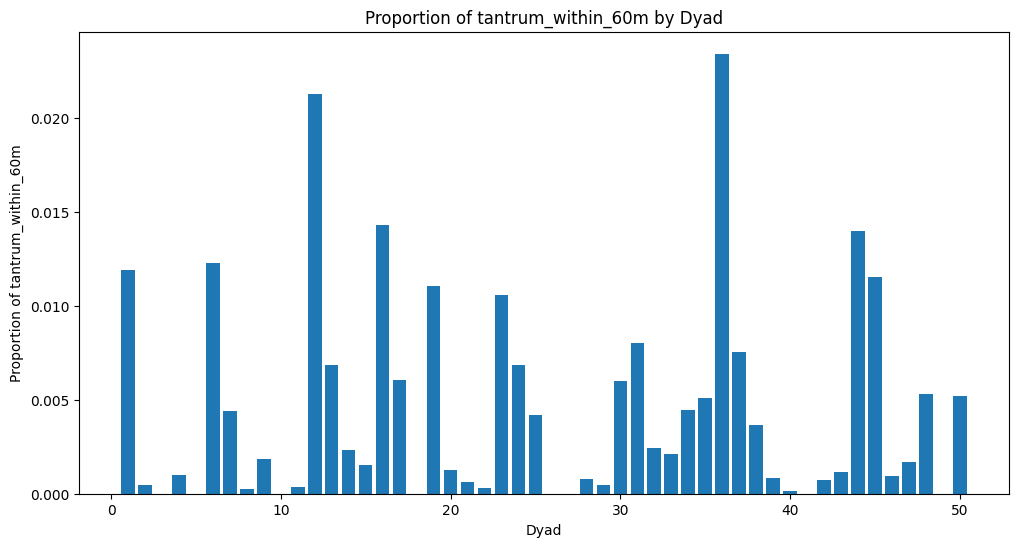

In [3]:
import matplotlib.pyplot as plt

dyads = df["dyad"].unique()
proportions = {}
for dyad in dyads:
    dyad_df = df[df["dyad"] == dyad]
    proportions[dyad] = (
        dyad_df["tantrum_within_60m"].sum() / len(dyad_df) if len(dyad_df) > 0 else 0
    )

plt.figure(figsize=(12, 6))
plt.bar(proportions.keys(), proportions.values())
plt.xlabel("Dyad")
plt.ylabel("Proportion of tantrum_within_60m")
plt.title("Proportion of tantrum_within_60m by Dyad")
plt.show()

In [4]:
no_tantrum_dyads = np.array([k for k, v in proportions.items() if v == 0])
tantrum_df = df[~df["dyad"].isin(no_tantrum_dyads)]
tantrum_dyads = tantrum_df["dyad"].unique()

In [5]:
from sklearn.model_selection import train_test_split

train_dyads, test_dyads = train_test_split(tantrum_dyads, test_size=0.2, random_state=2)

tantrum_df = clean_data(tantrum_df)
train_df = tantrum_df[tantrum_df["dyad"].isin(train_dyads)]
test_df = tantrum_df[tantrum_df["dyad"].isin(test_dyads)]

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_22528/979928551.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])
/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_22528/979928551.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["therapy_length_days"] = (
/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_22528/979928551.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [6]:
X_train, y_train = prep_X_y(train_df, "tantrum_within_60m")
X_test, y_test = prep_X_y(test_df, "tantrum_within_60m")

In [7]:
from numpy import logspace
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm.auto import tqdm

results = []

for spw in tqdm(logspace(0, 9, num=10, base=10)):
    model = xgb.XGBClassifier(scale_pos_weight=spw)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    results.append(
        {"scale_pos_weight": spw, "f1": f1, "precision": precision, "recall": recall}
    )

  0%|          | 0/10 [00:00<?, ?it/s]

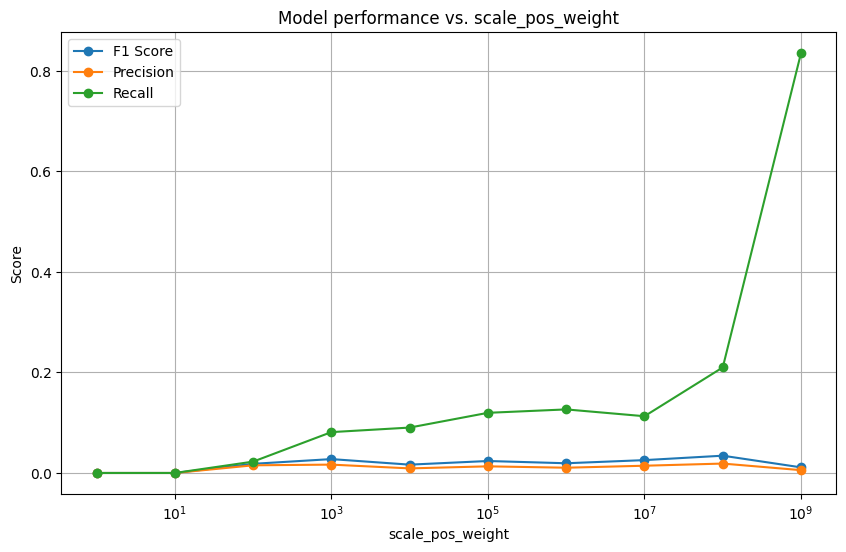

In [15]:
import matplotlib.pyplot as plt

spw_values = [r["scale_pos_weight"] for r in results]
f1_scores = [r["f1"] for r in results]
precisions = [r["precision"] for r in results]
recalls = [r["recall"] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(spw_values, f1_scores, marker="o", label="F1 Score")
plt.plot(spw_values, precisions, marker="o", label="Precision")
plt.plot(spw_values, recalls, marker="o", label="Recall")
plt.xscale("log")
plt.xlabel("scale_pos_weight")
plt.ylabel("Score")
plt.title("Model performance vs. scale_pos_weight")
plt.legend()
plt.grid(True)
plt.show()